Project 3: A Deep Learning Conv/Deconv Model for Video Compression
===

### Author: Utku Turkbey
### Contact: turkbey.utku@gmail.com

In this project, a simple deep learning network for basic video compression is implemented.


---

## 1. Preparation of the environment

### Prepare the data

The video data for train/test is at https://drive.google.com/drive/folders/1-3jkYvdTxxJmLG4WSps95w55_GL7naBc?usp=sharing.

The image data for training is at https://drive.google.com/drive/folders/1--iDlKbCuD4bYmSXUj7CrP-u4EezqGyv?usp=sharing. 

1. Put those folder (and the data inside of course) in your GoogleDrive.
2. Run the command below to mount the GoogleDrive onto Colab.
3. Check the path to the data (`'/content/drive/MyDrive/ELEC5306-2022'`)

In [1]:
from google.colab import drive
drive.mount('/content/drive') # Mount the GoogleDrive onto Colab

ModuleNotFoundError: No module named 'google.colab'

In [2]:
!ls /content/drive/MyDrive/ELEC5306-2022 # Check the data path

Image  valid  Video


In [3]:
!nvidia-smi # Check if the GPU is used and the model for GPU

Sun Jun  5 18:17:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---

## 2. Coding

Implementation of helper functions, compression model, necessary paramters and training. 

1. Import necessary packages. 

In [4]:
# ################################################
# import packages

import argparse
import time
import math
import random
import shutil
import sys
import glob

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms


from pathlib import Path

from PIL import Image
from torch.utils.data import Dataset

#For plotting learning curves
from IPython import display
import matplotlib.pyplot as plt

#For displaying demo results
import torchvision
import numpy as np

2. Define a Dataset classes that could iterate over images and videos under a directory. 

In [5]:
# ################################################
# ImageFolder Dataset (SAME WITH TEMPLATE)

class ImageFolder(Dataset):
    """Load an image folder database. Training and testing image samples
    are respectively stored in separate directories:

    .. code-block::

        - rootdir/
            - train/
                - img000.png
                - img001.png
                ...
            - valid/
                - img000.png
                - img001.png
                ...

    Args:
        root (string): root directory of the dataset
        transform (callable, optional): a function or transform that takes in a
            PIL image and returns a transformed version
    """

    def __init__(self, root, transform=None):
        splitdir = Path(root)

        if not splitdir.is_dir():
            raise RuntimeError(f'Invalid directory "{root}"')

        self.samples = [f for f in splitdir.iterdir() if f.is_file()]

        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            img: `PIL.Image.Image` or transformed `PIL.Image.Image`.
        """
        img = Image.open(self.samples[index]).convert("RGB")
        if self.transform:
            return self.transform(img)
        return img

    def __len__(self):
        return len(self.samples)

In [6]:
# ################################################
# SequenceFolder Dataset (SAME WITH TEMPLATE)

class SequenceFolder(Dataset):
    """Load an image folder database. Training and testing image samples
    are respectively stored in separate directories:

    .. code-block::

        - rootdir/
            - train/
              - video 1
                - img000.png
                - img001.png
                ...
              - video 2
                - img000.png
                - img001.png
                ...
            - test/
              - video 1
                - img000.png
                - img001.png
                ...
              - video 2
                - img000.png
                - img001.png
                ...

    Args:
        root (string): root directory of the dataset
        transform (callable, optional): a function or transform that takes in a
            PIL image and returns a transformed version
        split (string): split mode ('train' or 'val')
    """

    def __init__(self, root, transform=None, split="train"):
        self.mode = split
        splitdir = Path(root) / split

        if not splitdir.is_dir():
            raise RuntimeError(f'Invalid directory "{root}"')

        self.samples = self.get_all_images(splitdir)

        self.transform = transform

    def get_all_images(self, direc):
        self.images = []
        self.image_sequence = []
        self.sequences = [f for f in direc.iterdir() if f.is_dir()]
        for sd in self.sequences:
            images = []
            for f in (sd / 'img').iterdir():
                if f.is_file():
                  images.append(f)
            self.image_sequence.append(images)
            self.images = self.images + list(sorted(images))

        return self.images

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            img: `PIL.Image.Image` or transformed `PIL.Image.Image`.
        """
        img = Image.open(self.samples[index]).convert("RGB")
        if self.transform:
            return self.transform(img)
        return img

    def __len__(self):
        return len(self.samples)

3. Define the Conv/Deconv based compression neural network.

In [7]:
# ###################################################
# a baseline model (SAME WITH TEMPLATE)

def conv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
    )


def deconv(in_channels, out_channels, kernel_size=5, stride=2):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
    )


class Network(nn.Module):

    def __init__(self, N, M, init_weights=True, **kwargs):
        super().__init__(**kwargs)

        self.g_a = nn.Sequential(
            conv(3, N),
            conv(N, N),
            conv(N, N),
            conv(N, M),
        )

        self.g_s = nn.Sequential(
            deconv(M, N),
            deconv(N, N),
            deconv(N, N),
            deconv(N, 3),
        )

        self.N = N
        self.M = M

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        y = self.g_a(x)
        x_hat = self.g_s(y)

        return {
            "x_hat": x_hat,
        }

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def compress(self, x):
        y = self.g_a(x)
        return y

    def decompress(self, y_hat):
        x_hat = self.g_s(y_hat).clamp_(0, 1)
        return {"x_hat": x_hat}


4. Define other ingredients for training and testing.

In [8]:
# (SAME WITH TEMPLATE)

class Loss(nn.Module):

    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        out = {}
        out["mse_loss"] = self.mse(output["x_hat"], target)
        out["loss"] = out["mse_loss"] * 255

        return out

In [9]:
# (SAME WITH TEMPLATE)

class AverageMeter:
    """Compute running average."""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
# (SAME WITH TEMPLATE)

def configure_optimizers(net, learning_rate):

    optimizer = optim.Adam(
        net.parameters(),
        lr=learning_rate,
    )

    return optimizer

In [11]:
# (SAME WITH TEMPLATE)

def save_checkpoint(state, is_best, filename="checkpoint.pth.tar"):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, "checkpoint_best_loss.pth.tar")

In [12]:
# (SAME WITH TEMPLATE)

def PSNR(img1, img2):
    # img1 and img2 within range [0, 1]
    # img1 shape: (B, C, H, W)
    # img2 shape: (B, C, H, W)
    
    img1, img2 = img1.detach(), img2.detach()
    img1 = img1 * 255
    img2 = img2 * 255
    batch_size = img1.shape[0]
    img1 = img1.reshape(batch_size, -1)
    img2 = img2.reshape(batch_size, -1)
    mse = torch.mean((img1 - img2) ** 2)
    return torch.mean(20 * torch.log10(255.0 / torch.sqrt(mse)))

5. Define training and testing functions for one epoch.

5.1. Define a `train_one_epoch` function for training the model for one epoch.

In [14]:
# (SAME WITH TEMPLATE)

def train_one_epoch(
    model, criterion, train_dataloader, optimizer, epoch, clip_max_norm
):
    model.train()
    device = next(model.parameters()).device

    for i, d in enumerate(train_dataloader):
        d = d.to(device)

        optimizer.zero_grad()

        out_net = model(d)

        out_criterion = criterion(out_net, d)
        out_criterion["loss"].backward()
        if clip_max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        optimizer.step()

        if i % 10 == 0:
            print(
                f"Train epoch {epoch}: ["
                f"{i*len(d)}/{len(train_dataloader.dataset)}"
                f" ({100. * i / len(train_dataloader):.0f}%)]"
                f'\tLoss: {out_criterion["loss"].item():.3f} |'
                f'\tMSE loss: {out_criterion["mse_loss"].item():.3f}'
            )


5.2. Likewise further define a `test_epoch` function. 

In [15]:
#Fundamentally same with the template function but customized for efficiency by using dataloaders.
#A new parameter test_type added to test with either images or videos.
#Average test PSNR value is also returned with average loss for plotting purposes.

def test_epoch(epoch, test_dataset, test_transform, model, criterion, test_type="video"):
    model.eval()
    device = next(model.parameters()).device

    mse_loss = AverageMeter()
    psnr = AverageMeter()

    if test_type == "video":
        with torch.no_grad():
            for f in test_dataset.sequences: # Rather than directly looping over the scenes of videos stored in SequenceFolder.image_sequence, every video path in SequenceFolder.sequences are looped.
                psnr_video = AverageMeter()
                video = ImageFolder(f/"img", transform=test_transform) # For every video path, an ImageFolder dataset object is initialized using subfolder path named "/img". 
                video_loader = DataLoader(video, batch_size=256, num_workers=16, shuffle=False, pin_memory=(device == "cuda")) #A new DataLoader is created for loading each ImageFolder object.          
                for i, images in enumerate(video_loader): #-ImageFolder objects created for each video is used for testing with DataLoader as an ordinary Image dataset. 
                                                          #-This operation loads scenes in videos much faster with parallelization and also conserves the individual PSNR and MSE loss for every video.
                    d = images.to(device)
                    out_net = model(d)
                    d_out = out_net['x_hat']
                    out_criterion = criterion(out_net, d)
                    psnr_video.update(PSNR(d, d_out))
                mse_loss.update(out_criterion["mse_loss"])
                psnr.update(psnr_video.avg)
        print(
            f"Test epoch {epoch}: Average losses:"
            f"\tMSE loss: {mse_loss.avg:.3f}"
            f'\tSequence-wise PSNR: {psnr.avg: .3f}\n'
        )

    elif test_type == "image": # Similat operation with image folders of videos but for ordinary image folders.
        with torch.no_grad():
            image_loader = DataLoader(test_dataset, batch_size=256, num_workers=16, shuffle=False, pin_memory=(device == "cuda"))
            for i, images in enumerate(image_loader):
                d = images.to(device)
                out_net = model(d)
                d_out = out_net['x_hat']
                out_criterion = criterion(out_net, d)
                psnr.update(PSNR(d, d_out))
            mse_loss.update(out_criterion["mse_loss"])
        print(
            f"Test epoch {epoch}: Average losses:"
            f"\tMSE loss: {mse_loss.avg:.3f}"
            f'\tSequence-wise PSNR: {psnr.avg: .3f}\n'
        )

    return (mse_loss.avg, psnr.avg)

6. Define a main function, and complete the whole training/testing process.

6.1. Define arguments for training/validation.

In [16]:
seed = 123                                        # for reproducibility
cuda = True                                       # use GPU
save = False                                      # save trained model
train_dataset_root = '/content/drive/MyDrive/ELEC5306-2022/Video' # path to the root of the Video dataset
test_dataset_root = '/content/drive/MyDrive/ELEC5306-2022/Video'  # path to the root of the Video dataset
checkpoint = False                                # load pretrained model
epochs = 41                                       # total training epochs
clip_max_norm = 1.0                               # avoid gradient explosion
patch_size = (256, 256)                           # input size for the training network
learning_rate = 1e-4  
batch_size = 16
test_batch_size = 16 
num_workers = batch_size                          # multi-process for loading training data 
N = 128
M = 192 

In [17]:
# This cell is almost same with template except random padding in transformers and printing dataset sizes.

torch.manual_seed(seed)
random.seed(seed)

#Define transformations
train_transforms = transforms.Compose(
    [transforms.RandomCrop(patch_size, pad_if_needed =True ), transforms.ToTensor()] #Random padding is used since some video scenes are smaller than patch_size.
)

test_transforms = transforms.Compose(
    [transforms.CenterCrop(patch_size), transforms.ToTensor()]
)

train_dataset = SequenceFolder(train_dataset_root, split="train", transform=train_transforms)
test_dataset = SequenceFolder(test_dataset_root, split="test", transform=None) #Transforms are applied during testing.

#print(f"# of training images = {len(train_dataset)}")
#print(f"# of testing images = {len(test_dataset)}")

device = "cuda" if cuda and torch.cuda.is_available() else "cpu"

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=(device == "cuda"),
)

net = Network(N, M)
net = net.to(device)

optimizer = configure_optimizers(net, learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min")
criterion = Loss()

6.2. Main function for training and testing

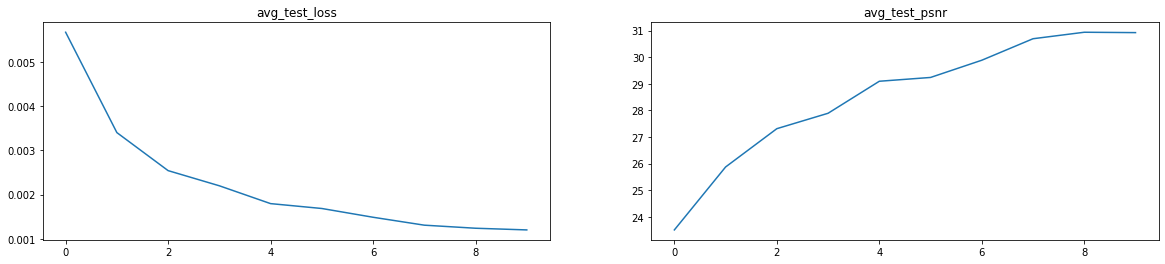

the overall training time (exclude testing) is 31.994195413589477 min


In [21]:
last_epoch = 1
if checkpoint:  # load from previous checkpoint
    print("Loading", checkpoint)
    checkpoint = torch.load(checkpoint, map_location=device)
    last_epoch = checkpoint["epoch"] + 1
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

best_loss = float("inf")
train_time = AverageMeter()

#Variables to hold the average MSE loss and PSNR test values for each epoch
loss_values = []
psnr_values = []

for epoch in range(last_epoch, epochs):
    if train_time.sum < 1800: # To enforce 30 mins training time limit. However there is a bug: since train_time is updated at the end of every training, if a training epoch has started before 30 mins, even if it passes 30 mins is keeps on training untill that last epoch finishes. 
        print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
        epoch_train_start = time.time()
        train_one_epoch(
            net,
            criterion,
            train_dataloader,
            optimizer,
            epoch,
            clip_max_norm,
        )
        epoch_train_end = time.time()
        train_time.update(epoch_train_end - epoch_train_start)
        print(f"Train epoch {epoch}: {epoch_train_end - epoch_train_start} seconds")
        loss, psnr = test_epoch(epoch, test_dataset, test_transforms, net, criterion, test_type="video")
        lr_scheduler.step(loss)

        #update the loss and psnr test values after every epoch
        loss_values.append(loss.item())
        psnr_values.append(psnr.item())

        is_best = loss < best_loss
        best_loss = min(loss, best_loss)

        if save:
            save_checkpoint(
                {
                    "epoch": epoch,
                    "state_dict": net.state_dict(),
                    "loss": loss,
                    "optimizer": optimizer.state_dict(),
                    "lr_scheduler": lr_scheduler.state_dict(),
                },
                is_best,
            )
print('the overall training time (exclude testing) is {} min'.format(train_time.sum / 60))

## 3. Results

Plot learning curves and display sample compressed images from dataset for demonstration.

In [ ]:
font = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

plt.figure(1, (18, 5))

plt.subplot(121)
plt.plot(loss_values)
plt.xlabel("Epoch", fontdict=font)
plt.ylabel("Loss", fontdict=font)
plt.title("Average Test Loss (MSE)", fontdict=font)

plt.subplot(122)
plt.plot(psnr_values)
plt.xlabel("Epoch", fontdict=font)
plt.ylabel("dB", fontdict=font)
plt.title("Average Test PSNR", fontdict=font)

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

demo_dataset_root = '/content/drive/MyDrive/ELEC5306-2022/valid'
demo_dataset = ImageFolder(demo_dataset_root, transform=test_transforms)
demo_dataloader = DataLoader(demo_dataset, batch_size=4, num_workers=1, shuffle=True, pin_memory=(device == "cuda"))

demo_images_original = iter(demo_dataloader).next().to(device)
demo_images_compressed = net(demo_images_original)["x_hat"]
demo_images = torch.cat((demo_images_original, demo_images_compressed)).to("cpu")

imshow(torchvision.utils.make_grid(demo_images, nrow=4))

## 4. Benchmark Test



In [24]:
!pip install pthflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
from pthflops import count_ops

MAX_GFLOPS = 3000
MIN_RATIO = 0.7

def benchmark(yournet):
    yournet = yournet.cuda()
    x = torch.randn((1, 3, 500, 500)).cuda()
    try:
      yournet.compress(x)
    except AttributeError:
      print('does your network have a ```def compress(self, input)``` function?')
      print('refer to the baseline model in the template')
      return

    est, _ = count_ops(yournet, x, print_readable=False, verbose=False)
    est = int(est / 1e9)
    if est <= MAX_GFLOPS:
      print('#' * 30)
      print('[Acceptable Model Complexity]')
      print(est)
      print('#' * 30)
      print('\n')
    else:
      assert 0, 'Your model complexity is {} GFLOPS, the acceptable maximum is {} GFLOPS. Make your model smaller'.format(est, MAX_GFLOPS)

    compressed = yournet.compress(x)
    ratio = 1 - compressed.numel() / x.numel()
    if ratio >= MIN_RATIO:
      print('#' * 30)
      print('[Acceptable Compression Ratio]')
      print(ratio)
      print('#' * 30)
    else:
      assert 0, 'Current compression ratio is {} , the acceptable lowest ratio is {}. Make it higher'.format(ratio, MIN_RATIO)

    print('you can move on :)')

benchmark(net)


##############################
[Acceptable Model Complexity]
47
##############################


##############################
[Acceptable Compression Ratio]
0.7378560000000001
##############################
you can move on :)
